In [9]:
# Imports
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import gaussian_kde
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.backends.backend_pdf
plt.style.use('seaborn-notebook')

In [5]:
# load example session
filename = Path('data/dryad/Swimming/N2_Adult/020422_N2_A1_Swim_0001_W1_.txt')
data = np.loadtxt(filename, dtype= 'float', skiprows=1)
time = data[:, 0]
angles = data[:,1:]

Text(0.5, 0.98, '020422_N2_A1_Swim_0001_W1_.txt Kymograph')

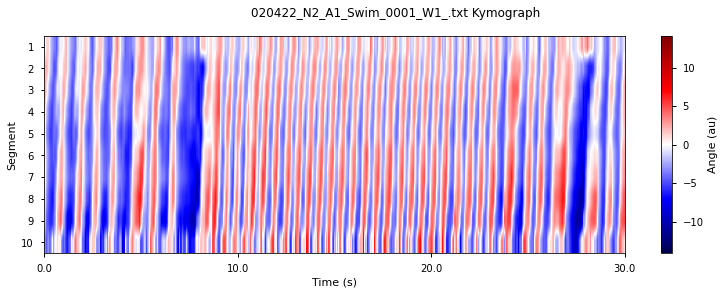

In [16]:
# plot kymograph of session
timestep = 10 # seconds
xtimes = np.arange(min(time), max(time), timestep)
xticks = []
for i in xtimes:
    ind = np.searchsorted(time, i)
    xticks.append(ind)
    xticklabels = [str(i) for i in xtimes]

clip = 30 # clip the data at 30s
if clip is not None:
        stop_idx = (np.abs(time - clip)).argmin()
# Set segment ticks and labels
yticks = np.arange(0, 10)
yticklabels = reversed([str(i+1) for i in yticks])

# vs = 1 #hard limit
vs = max([abs(np.amin(angles)), abs(np.amax(angles))])

fig, ax = plt.subplots(figsize=(13, 4))
im = ax.imshow(angles.T, aspect='auto', cmap='seismic', origin='lower',
                vmin=-vs, vmax=vs)
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
ax.set_xlabel('Time (s)')
if clip is not None:
        ax.set_xlim([0, stop_idx])
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels)
ax.set_ylabel('Segment')
fig.colorbar(im, label='Angle (au)', ax=ax)
fig.suptitle(f'{filename.name} Kymograph')

In [6]:
# Normalize the data
scaler = StandardScaler()  # initialize a standardizing object
angles_norm = scaler.fit_transform(angles) # normalize the data
# Run PCA
pca = PCA(n_components=10)  # initialize a pca object
pcs = pca.fit_transform(angles_norm)  # fit and transform the angles data

In [7]:
#calculate summary statistics

# cumulative variance explained
cumvar = np.cumsum(np.hstack(([0], pca.explained_variance_ratio_))) 

# 2D PC loadings histogram (kernel density estimate)
kde = gaussian_kde(pcs[:,0:2].T)
xmin = np.min(pcs[:,0])
xmax = np.max(pcs[:,0])
ymin = np.min(pcs[:,1])
ymax = np.max(pcs[:,1])

X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
Z = np.reshape(kde(positions).T, X.shape)

# segment covariance matrix
C = np.cov(angles_norm.T) # data must be (n_segments, n_frames)


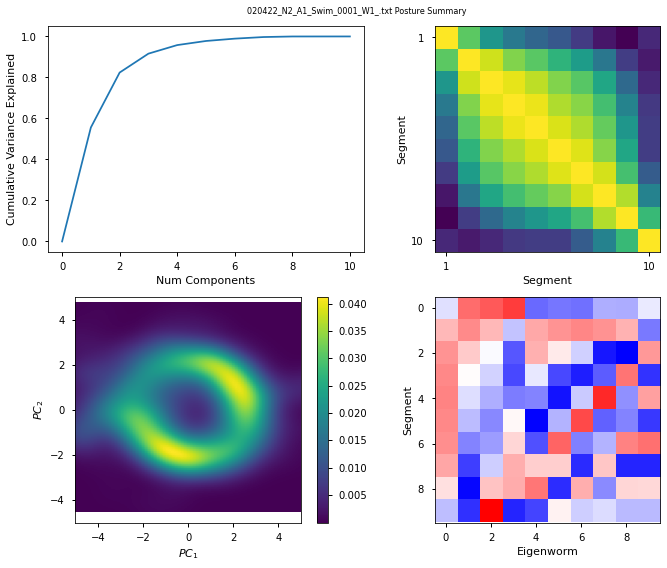

In [17]:
#plotting
fig = plt.figure(figsize=(10, 8))
gs = GridSpec(2,2, figure=fig)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[1,0])
ax4 = fig.add_subplot(gs[1,1])

#cumulative variance explained
ax = ax1
ax.plot(cumvar)
ax.set(xticks = np.arange(11, step=2),
    xticklabels = ['0', '2', '4', '6', '8', '10'], xlabel = "Num Components",
    ylabel = "Cumulative Variance Explained")

# Covariance structure
ax = ax2
im2 = ax.imshow(C)
ax.set(xticks=[0,9], xticklabels=['1', '10'], xlabel='Segment',
        yticks=[0,9], yticklabels=['1', '10'], ylabel='Segment')
#2D PC distribution
ax=ax3
im1 = ax.imshow(np.rot90(Z), cmap='viridis',
        extent=[xmin, xmax, ymin, ymax])
ax.set(xlim = [-5, 5], ylim = [-5, 5], xlabel = r"$PC_1$", ylabel = r"$PC_2$")
plt.colorbar(im1, ax=ax)

#eigenworms
ax = ax4
im2 = ax.imshow(pca.components_.T, cmap='bwr')
ax.set(xlabel="Eigenworm", ylabel = "Segment")

fig.suptitle(f'{filename.name} Posture Summary', size=8)
fig.tight_layout()